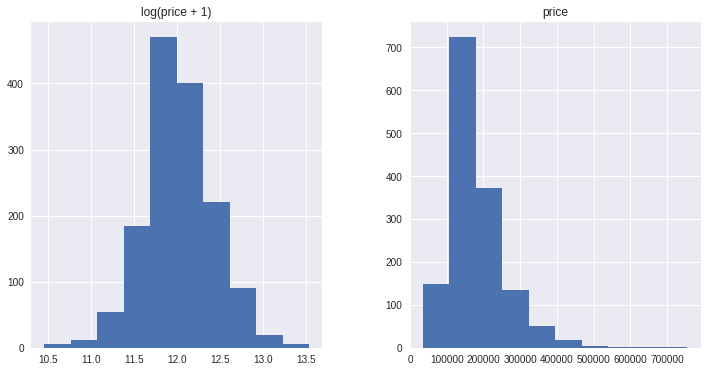

In [60]:
import pandas as pd
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
import xgboost as xgb

train = pd.read_csv("~/Downloads/input/train.csv")
test = pd.read_csv("~/Downloads/input/test.csv")

combined = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()
plt.show()

#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_features = combined.dtypes[combined.dtypes != "object"].index

skewed_features = train[numeric_features].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_features = skewed_features[skewed_features > 0.75]
skewed_features = skewed_features.index

combined[skewed_features] = np.log1p(combined[skewed_features])
combined = pd.get_dummies(combined)

#filling NA's with the mean of the column:
combined = combined.fillna(combined.mean())

X_train = combined[:train.shape[0]]
X_test = combined[train.shape[0]:]
y = train.SalePrice

In [67]:
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=800, early_stopping_rounds=50)

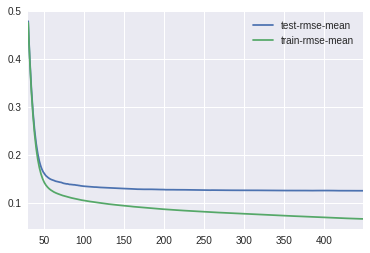

In [68]:
%matplotlib inline
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [69]:
model

,test-rmse-mean,test-rmse-std,train-rmse-mean,train-rmse-std
0,10.380138,0.007834,10.380139,0.003413
1,9.344810,0.008219,9.344813,0.003153
2,8.413089,0.008584,8.413092,0.002927
3,7.574992,0.008599,7.574618,0.002707
4,6.820292,0.008262,6.819935,0.002493
5,6.140506,0.008449,6.140691,0.002305
6,5.529961,0.007377,5.529318,0.002142
7,4.979715,0.007124,4.979068,0.001986
8,4.484608,0.007024,4.483856,0.001864
9,4.039001,0.006651,4.038170,0.001761


In [21]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
model = xgb.XGBRegressor()
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
param_grid = dict(learning_rate=learning_rate)
grid_search = GridSearchCV(model, param_grid, scoring="neg_mean_squared_error")
grid_result = grid_search.fit(X_train, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
mean_score = grid_result.cv_results_['mean_test_score']
std_score = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(mean_score, std_score, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.017485 using {'learning_rate': 0.1}
-130.336200 (0.218290) with: {'learning_rate': 0.0001}
-108.901566 (0.208163) with: {'learning_rate': 0.001}
-17.952806 (0.088206) with: {'learning_rate': 0.01}
-0.017485 (0.002475) with: {'learning_rate': 0.1}
-0.018178 (0.003310) with: {'learning_rate': 0.2}
-0.018416 (0.003180) with: {'learning_rate': 0.3}


In [26]:
model = xgb.XGBRegressor(learning_rate=0.1, n_estimators=300)
param1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
grid_search = GridSearchCV(model, param1, scoring="neg_mean_squared_error")
grid_result = grid_search.fit(X_train, y)
#grid_result.cv_results_
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
mean_score = grid_result.cv_results_['mean_test_score']
std_score = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(mean_score, std_score, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.015905 using {'max_depth': 3, 'min_child_weight': 3}
-0.015919 (0.002569) with: {'max_depth': 3, 'min_child_weight': 1}
-0.015905 (0.002868) with: {'max_depth': 3, 'min_child_weight': 3}
-0.016335 (0.002120) with: {'max_depth': 3, 'min_child_weight': 5}
-0.016998 (0.003273) with: {'max_depth': 5, 'min_child_weight': 1}
-0.016672 (0.003795) with: {'max_depth': 5, 'min_child_weight': 3}
-0.016142 (0.003071) with: {'max_depth': 5, 'min_child_weight': 5}
-0.017708 (0.003641) with: {'max_depth': 7, 'min_child_weight': 1}
-0.017050 (0.003822) with: {'max_depth': 7, 'min_child_weight': 3}
-0.017029 (0.003099) with: {'max_depth': 7, 'min_child_weight': 5}
-0.017796 (0.003589) with: {'max_depth': 9, 'min_child_weight': 1}
-0.017329 (0.003796) with: {'max_depth': 9, 'min_child_weight': 3}
-0.017375 (0.003130) with: {'max_depth': 9, 'min_child_weight': 5}


In [29]:
model = xgb.XGBRegressor(learning_rate=0.1, n_estimators=300)
param2 = {
 'max_depth':[2,3,4],
 'min_child_weight':[1,2,3,4]
}
grid_search = GridSearchCV(model, param2, scoring="neg_mean_squared_error")
grid_result = grid_search.fit(X_train, y)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
mean_score = grid_result.cv_results_['mean_test_score']
std_score = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(mean_score, std_score, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.015658 using {'max_depth': 3, 'min_child_weight': 2}
-0.015804 (0.002579) with: {'max_depth': 2, 'min_child_weight': 1}
-0.015980 (0.002469) with: {'max_depth': 2, 'min_child_weight': 2}
-0.016370 (0.002659) with: {'max_depth': 2, 'min_child_weight': 3}
-0.016670 (0.002689) with: {'max_depth': 2, 'min_child_weight': 4}
-0.015919 (0.002569) with: {'max_depth': 3, 'min_child_weight': 1}
-0.015658 (0.003028) with: {'max_depth': 3, 'min_child_weight': 2}
-0.015905 (0.002868) with: {'max_depth': 3, 'min_child_weight': 3}
-0.016404 (0.002648) with: {'max_depth': 3, 'min_child_weight': 4}
-0.016525 (0.003227) with: {'max_depth': 4, 'min_child_weight': 1}
-0.016000 (0.003105) with: {'max_depth': 4, 'min_child_weight': 2}
-0.016206 (0.003013) with: {'max_depth': 4, 'min_child_weight': 3}
-0.016308 (0.003117) with: {'max_depth': 4, 'min_child_weight': 4}


In [30]:
param3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
model = xgb.XGBRegressor(learning_rate=0.1, n_estimators=300,max_depth=3,
 min_child_weight=2)
grid_search = GridSearchCV(model, param3, scoring="neg_mean_squared_error")
grid_result = grid_search.fit(X_train, y)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
mean_score = grid_result.cv_results_['mean_test_score']
std_score = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(mean_score, std_score, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.015658 using {'gamma': 0.0}
-0.015658 (0.003028) with: {'gamma': 0.0}
-0.018313 (0.002724) with: {'gamma': 0.1}
-0.019572 (0.002586) with: {'gamma': 0.2}
-0.021161 (0.003072) with: {'gamma': 0.3}
-0.022150 (0.003341) with: {'gamma': 0.4}


In [32]:
def test(param):
    grid_search = GridSearchCV(model, param, scoring="neg_mean_squared_error")
    grid_result = grid_search.fit(X_train, y)
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    mean_score = grid_result.cv_results_['mean_test_score']
    std_score = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(mean_score, std_score, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
param4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
model = xgb.XGBRegressor(learning_rate=0.1, n_estimators=300,max_depth=3,
 min_child_weight=2)
test(param4)

Best: -0.015126 using {'subsample': 0.9, 'colsample_bytree': 0.9}
-0.015963 (0.002584) with: {'subsample': 0.6, 'colsample_bytree': 0.6}
-0.015725 (0.002412) with: {'subsample': 0.7, 'colsample_bytree': 0.6}
-0.015203 (0.002586) with: {'subsample': 0.8, 'colsample_bytree': 0.6}
-0.015161 (0.002484) with: {'subsample': 0.9, 'colsample_bytree': 0.6}
-0.016002 (0.002471) with: {'subsample': 0.6, 'colsample_bytree': 0.7}
-0.016050 (0.002785) with: {'subsample': 0.7, 'colsample_bytree': 0.7}
-0.015341 (0.002601) with: {'subsample': 0.8, 'colsample_bytree': 0.7}
-0.015591 (0.002947) with: {'subsample': 0.9, 'colsample_bytree': 0.7}
-0.016308 (0.002392) with: {'subsample': 0.6, 'colsample_bytree': 0.8}
-0.015981 (0.002641) with: {'subsample': 0.7, 'colsample_bytree': 0.8}
-0.015227 (0.002273) with: {'subsample': 0.8, 'colsample_bytree': 0.8}
-0.015927 (0.002341) with: {'subsample': 0.9, 'colsample_bytree': 0.8}
-0.015908 (0.002986) with: {'subsample': 0.6, 'colsample_bytree': 0.9}
-0.015557 (

In [33]:
param5 = {
 'subsample':[i/100.0 for i in range(85,100,5)],
 'colsample_bytree':[i/100.0 for i in range(85,100,5)]
}
model = xgb.XGBRegressor(learning_rate=0.1, n_estimators=300,max_depth=3,
 min_child_weight=2)
test(param5)

Best: -0.015126 using {'subsample': 0.9, 'colsample_bytree': 0.9}
-0.015429 (0.003192) with: {'subsample': 0.85, 'colsample_bytree': 0.85}
-0.015501 (0.002776) with: {'subsample': 0.9, 'colsample_bytree': 0.85}
-0.015876 (0.002455) with: {'subsample': 0.95, 'colsample_bytree': 0.85}
-0.015292 (0.002573) with: {'subsample': 0.85, 'colsample_bytree': 0.9}
-0.015126 (0.002691) with: {'subsample': 0.9, 'colsample_bytree': 0.9}
-0.015945 (0.003075) with: {'subsample': 0.95, 'colsample_bytree': 0.9}
-0.015544 (0.002726) with: {'subsample': 0.85, 'colsample_bytree': 0.95}
-0.015815 (0.003030) with: {'subsample': 0.9, 'colsample_bytree': 0.95}
-0.015851 (0.003115) with: {'subsample': 0.95, 'colsample_bytree': 0.95}


In [35]:
param6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
 'reg_lambda':[1e-5, 1e-2, 0.1, 1, 100]
}
model = xgb.XGBRegressor(learning_rate=0.1, n_estimators=300,max_depth=3,
 min_child_weight=2,subsample=0.9,colsample_bytree=0.9)
test(param6)

Best: -0.015081 using {'reg_alpha': 0.01, 'reg_lambda': 1}
-0.016263 (0.003236) with: {'reg_alpha': 1e-05, 'reg_lambda': 1e-05}
-0.015716 (0.002556) with: {'reg_alpha': 1e-05, 'reg_lambda': 0.01}
-0.015813 (0.003126) with: {'reg_alpha': 1e-05, 'reg_lambda': 0.1}
-0.015104 (0.002695) with: {'reg_alpha': 1e-05, 'reg_lambda': 1}
-0.017630 (0.001257) with: {'reg_alpha': 1e-05, 'reg_lambda': 100}
-0.015810 (0.002948) with: {'reg_alpha': 0.01, 'reg_lambda': 1e-05}
-0.016203 (0.002808) with: {'reg_alpha': 0.01, 'reg_lambda': 0.01}
-0.016106 (0.003434) with: {'reg_alpha': 0.01, 'reg_lambda': 0.1}
-0.015081 (0.002630) with: {'reg_alpha': 0.01, 'reg_lambda': 1}
-0.017706 (0.001224) with: {'reg_alpha': 0.01, 'reg_lambda': 100}
-0.015280 (0.002358) with: {'reg_alpha': 0.1, 'reg_lambda': 1e-05}
-0.015691 (0.002416) with: {'reg_alpha': 0.1, 'reg_lambda': 0.01}
-0.015544 (0.002675) with: {'reg_alpha': 0.1, 'reg_lambda': 0.1}
-0.015740 (0.002640) with: {'reg_alpha': 0.1, 'reg_lambda': 1}
-0.017537 (0.

In [36]:
param7 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05],
'reg_lambda':[0.8, 0.9, 1, 1.1, 1.2]
}
model = xgb.XGBRegressor(learning_rate=0.1, n_estimators=300,max_depth=3,
 min_child_weight=2,subsample=0.9,colsample_bytree=0.9)
test(param6)

Best: -0.015081 using {'reg_alpha': 0.01, 'reg_lambda': 1}
-0.016263 (0.003236) with: {'reg_alpha': 1e-05, 'reg_lambda': 1e-05}
-0.015716 (0.002556) with: {'reg_alpha': 1e-05, 'reg_lambda': 0.01}
-0.015813 (0.003126) with: {'reg_alpha': 1e-05, 'reg_lambda': 0.1}
-0.015104 (0.002695) with: {'reg_alpha': 1e-05, 'reg_lambda': 1}
-0.017630 (0.001257) with: {'reg_alpha': 1e-05, 'reg_lambda': 100}
-0.015810 (0.002948) with: {'reg_alpha': 0.01, 'reg_lambda': 1e-05}
-0.016203 (0.002808) with: {'reg_alpha': 0.01, 'reg_lambda': 0.01}
-0.016106 (0.003434) with: {'reg_alpha': 0.01, 'reg_lambda': 0.1}
-0.015081 (0.002630) with: {'reg_alpha': 0.01, 'reg_lambda': 1}
-0.017706 (0.001224) with: {'reg_alpha': 0.01, 'reg_lambda': 100}
-0.015280 (0.002358) with: {'reg_alpha': 0.1, 'reg_lambda': 1e-05}
-0.015691 (0.002416) with: {'reg_alpha': 0.1, 'reg_lambda': 0.01}
-0.015544 (0.002675) with: {'reg_alpha': 0.1, 'reg_lambda': 0.1}
-0.015740 (0.002640) with: {'reg_alpha': 0.1, 'reg_lambda': 1}
-0.017537 (0.

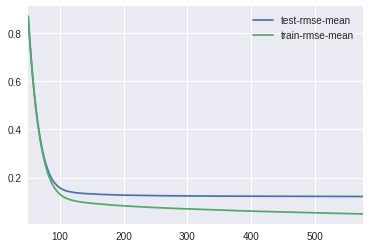

In [54]:
%matplotlib inline
alg = xgb.XGBRegressor(learning_rate=0.05, n_estimators=300,max_depth=3,
 min_child_weight=2,subsample=0.9,colsample_bytree=0.9, reg_alpha=0.01, reg_lambda=1)
xgb_param = alg.get_xgb_params()
model = xgb.cv(xgb_param, dtrain,  num_boost_round=800, early_stopping_rounds=50)
model.loc[50:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [51]:
model

,test-rmse-mean,test-rmse-std,train-rmse-mean,train-rmse-std
0,10.955325,0.007779,10.955327,0.003409
1,10.408946,0.007932,10.408948,0.003311
2,9.889926,0.007939,9.889928,0.003364
3,9.396584,0.007942,9.396586,0.003423
4,8.928008,0.008238,8.928011,0.003195
5,8.483090,0.008450,8.483092,0.003052
6,8.060709,0.008869,8.060713,0.002703
7,7.659269,0.008997,7.659084,0.002469
8,7.277841,0.009047,7.277501,0.002352
9,6.915332,0.008799,6.914998,0.002333


In [71]:
alg.fit(X_train, y)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.9,
       gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=3,
       min_child_weight=2, missing=None, n_estimators=300, nthread=-1,
       objective='reg:linear', reg_alpha=0.01, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.9)

In [73]:
print(alg.feature_importances_)

[ 0.00334821  0.02455357  0.06026786  0.04966518  0.04464286  0.03571429
  0.01674107  0.00613839  0.04296875  0.00669643  0.0234375   0.04129464
  0.02287946  0.01897321  0.00055804  0.06696428  0.00725446  0.00055804
  0.00725446  0.00334821  0.00390625  0.00334821  0.00334821  0.0078125
  0.02957589  0.00948661  0.02566964  0.01339286  0.01897321  0.01283482
  0.          0.01283482  0.00837054  0.00167411  0.01227679  0.01116071
  0.01897321  0.0078125   0.00223214  0.00279018  0.00334821  0.          0.
  0.          0.00279018  0.00279018  0.          0.          0.00334821
  0.00390625  0.          0.00167411  0.00167411  0.          0.
  0.00167411  0.00502232  0.          0.          0.00167411  0.00055804
  0.          0.          0.          0.          0.          0.00502232
  0.00334821  0.          0.01339286  0.00558036  0.          0.
  0.00055804  0.00558036  0.00223214  0.          0.00167411  0.
  0.00223214  0.00390625  0.          0.00167411  0.          0.00055804

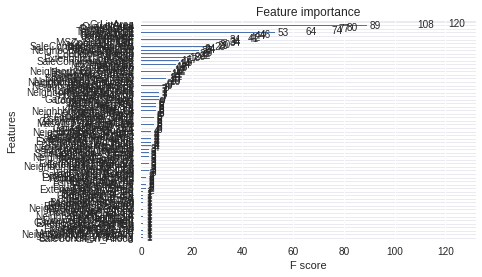

In [77]:
from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(alg)
pyplot.show()

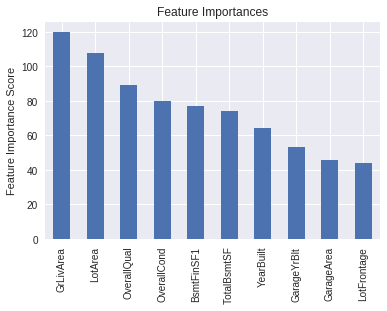

In [79]:
feat_importance = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)[0:10]
feat_importance.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [9]:
xgb_preds = np.expm1(alg.predict(X_test))


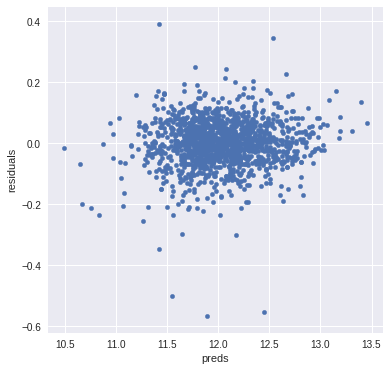

In [80]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

prediction = pd.DataFrame({"prediction":alg.predict(X_train), "true":y})
prediction["residuals"] = prediction["true"] - prediction["prediction"]
prediction.plot(x = "prediction", y = "residuals",kind = "scatter")

In [81]:
solution = pd.DataFrame({"id":test.Id, "SalePrice":xgb_preds})
solution.to_csv("xgb.csv", index = False)